In [2]:
import sys, os
import json
import pandas as pd
from pathlib import Path

sys.path.append(str(Path.cwd().parent / "src"))
from model_lstm import LSTMModel
from data_loader_lstm import LSTMDataLoader

In [36]:
# load configuration and saved XGBoost model
# Available COIN_ID options:
# - BTCUSDT: Bitcoin/USDT pair
# - ETHUSDT: Ethereum/USDT pair  
# - BNBUSDT: Binance Coin/USDT pair
# - SOLUSDT: Solana/USDT pair
# - XRPUSDT: Ripple/USDT pair

# Available FREQ (sampling frequency) options:
# - 10min: 10 minute intervals

# Define paths
coin_id = "ETHUSDT"
freq = "10min"
use_overlap = True

model_path = f"models/{coin_id}_{freq}/best_model.h5"
results_path = f"models/{coin_id}_{freq}/optimization_results.json"
with open(results_path, 'r') as f:
    saved_results = json.load(f)
    
data_config = saved_results['data_loader_config']
sequence_length = data_config['sequence_length']
# feature_columns = data_config['feature_columns']

In [ ]:
# Load data
data_loader = LSTMDataLoader(
    **data_config,
    use_overlap = use_overlap
)
X_train, y_train, X_test, y_test = data_loader.load_data()

# load model and predict
model = LSTMModel(input_shape=(1, 1))  # 1,1 are placeholder
model.load_model(model_path)
y_pred_proba = model.predict(X_test, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int)

Reducing memory usage for: processed_data
--- Memory usage before: 28.16 MB
--- Memory usage after: 15.59 MB
--- Decreased memory usage by 44.6%



# simulate strategy

In [30]:
from strategy_simulation import calculate_single_coin_return
from KPI import calculate_performance_metrics
import matplotlib.pyplot as plt
from data_processing import get_features_and_target

In [31]:
train_df, test_df = get_features_and_target(coin_id=coin_id, freq=freq, split=True)

if use_overlap:
    start_index = 0
else:
    start_index = sequence_length

result_df = pd.DataFrame({
    'timestamp': test_df['timestamp'].iloc[start_index:],
    'open': test_df['open'].iloc[start_index:],
    'close': test_df['close'].iloc[start_index:],
    'y_test_actual': y_test,
    'y_test_pred': y_pred.flatten(),
    'y_test_pred_proba': y_pred_proba.flatten()
})

# Save result_df to CSV
# result_csv_path = f'results/prediction_{coin_id}_{freq}_lstm.csv'
# result_df.to_csv(result_csv_path, index=False)

Reducing memory usage for: processed_data
--- Memory usage before: 28.16 MB
--- Memory usage after: 15.59 MB
--- Decreased memory usage by 44.6%



In [32]:
all_strategy_names = ['buy_and_hold', 'long_short', 'long_only', 'trend_following']
all_returns = dict()
for strategy in all_strategy_names:
    net_returns = calculate_single_coin_return(strategy, result_df=result_df)
    all_returns[strategy] = net_returns

timestamps = result_df['timestamp']

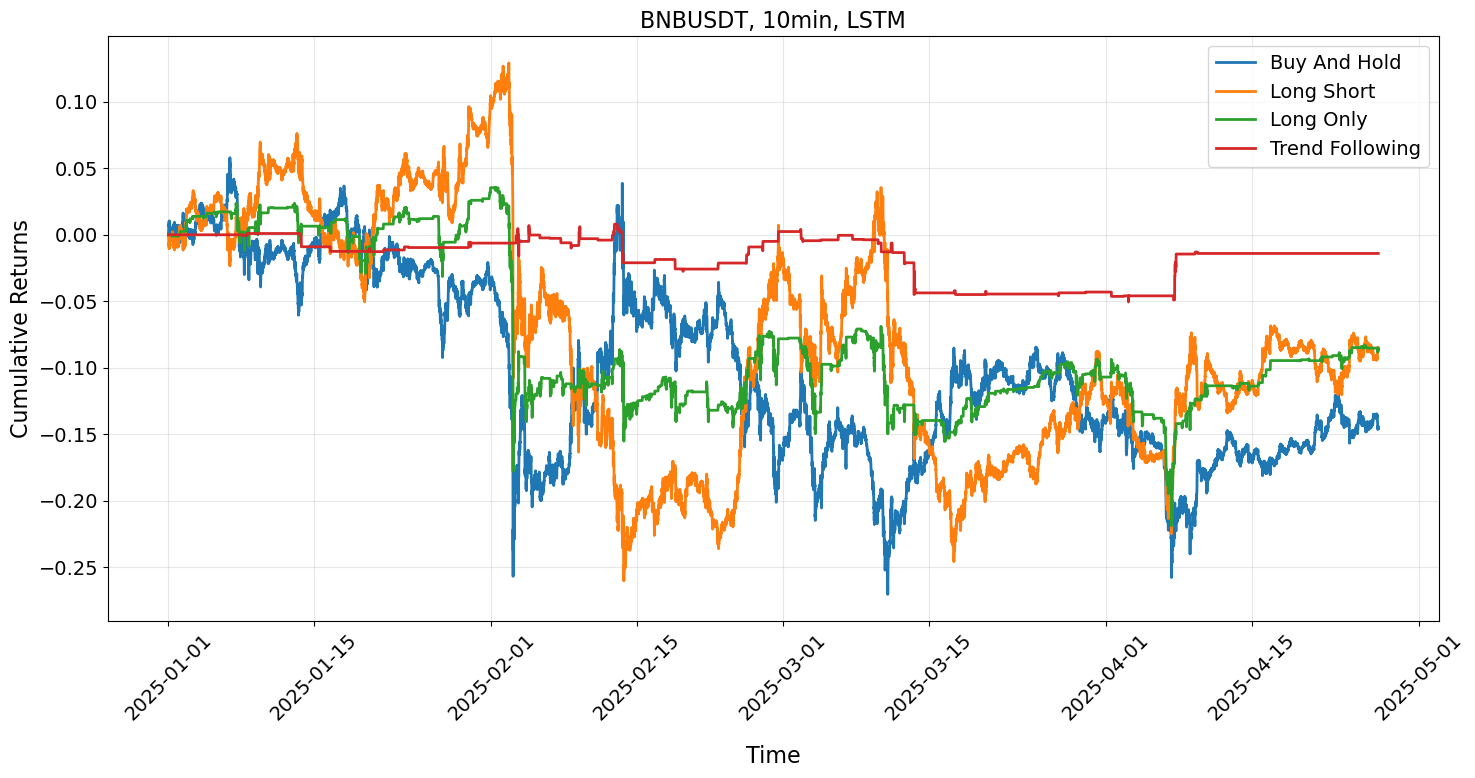

In [33]:
plt.figure(figsize=(15, 8))

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

for strategy, returns in all_returns.items():
    cumulative_returns = (1 + returns).cumprod() - 1
    plt.plot(timestamps, cumulative_returns, label=strategy.replace('_', ' ').title(), linewidth=2)


plt.xlabel('Time', labelpad=15)
plt.ylabel('Cumulative Returns')
plt.title(f'{coin_id}, {freq}, LSTM')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()

os.makedirs('/project/littlewood/Xiaoyuan/DS/ds_crypto_2025/LSTM/fig/', exist_ok=True)
plt.savefig(f'/project/littlewood/Xiaoyuan/DS/ds_crypto_2025/LSTM/fig/{coin_id}_{freq}_cumulative_returns.png', 
            dpi=300, 
            bbox_inches='tight')
            
plt.show()

In [34]:
all_kpis = []
for strategy, return_series in all_returns.items():
    kpis = calculate_performance_metrics(returns_series=return_series, freq=freq)
    record = {'strategy': strategy, "coin_id": coin_id, **kpis}
    all_kpis.append(record)

kpi_df = pd.DataFrame(all_kpis)
kpi_df['frequency'] = freq
kpi_df['model'] = 'LSTM'
kpi_df.reset_index(drop=True, inplace=True)
display(kpi_df)

,strategy,coin_id,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Maximum Drawdown,Calmar Ratio,Kelly Criterion,frequency,model
0,buy_and_hold,BNBUSDT,-0.079173,0.239467,-0.330621,-0.422998,-0.310295,-0.255153,-0.003781,10min,LSTM
1,long_short,BNBUSDT,-0.045335,0.239467,-0.189318,-0.234104,-0.344836,-0.131469,-0.001248,10min,LSTM
2,long_only,BNBUSDT,-0.046139,0.151469,-0.304611,-0.142270,-0.245871,-0.187656,-0.010603,10min,LSTM
3,trend_following,BNBUSDT,-0.007376,0.040101,-0.183932,-0.021522,-0.057998,-0.127174,-0.028653,10min,LSTM


In [35]:
# Create path for KPI results if it doesn't exist
kpi_results_path = '/project/littlewood/Xiaoyuan/DS/ds_crypto_2025/LSTM/'
os.makedirs(kpi_results_path, exist_ok=True)

# Define the CSV file path
kpi_csv_path = os.path.join(kpi_results_path, 'all_coins_kpi_results.csv')

# If file exists, append to it, otherwise create new
if os.path.exists(kpi_csv_path):
    # Read existing CSV
    existing_kpis = pd.read_csv(kpi_csv_path)
    
    # Remove any existing entries for current coin_id and frequency to avoid duplicates
    existing_kpis = existing_kpis[~((existing_kpis['coin_id'] == coin_id) & 
                                  (existing_kpis['frequency'] == freq) &
                                  (existing_kpis['model'] == 'LSTM'))]
    
    # Append new results
    updated_kpis = pd.concat([existing_kpis, kpi_df], ignore_index=True)
else:
    updated_kpis = kpi_df

# Save to CSV
updated_kpis.to_csv(kpi_csv_path, index=False)
print(f"KPI results saved to: {kpi_csv_path}")


KPI results saved to: /project/littlewood/Xiaoyuan/DS/ds_crypto_2025/LSTM/all_coins_kpi_results.csv
